In [1]:
pip install tensorflow-addons

     |████████████████████████████████| 1.8MB 6.1MB/s 
     |████████████████████████████████| 380.8MB 42kB/s 
     |████████████████████████████████| 3.8MB 37.7MB/s 
     |████████████████████████████████| 450kB 42.3MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Su

In [2]:
pip uninstall keras -y

Uninstalling Keras-2.2.5:
  Successfully uninstalled Keras-2.2.5


In [3]:
pip install keras

     |████████████████████████████████| 378kB 6.7MB/s 


In [4]:
# to run continually (without 'check-in'), type the following in console (cntrl+shift+i):
# function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,1200000)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy
import pickle

import keras
from keras.models import Model, Sequential
from keras.layers import Layer, Conv2D, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow_addons as tfa

from pathlib import Path
import cv2
import os
import imgaug as ia
import imgaug.augmenters as iaa
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
########################################################

# If running with Google Colab

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# network specifications
image_shape = (180, 180, 3) # image_shape: shape of images we will crop to. Also controls whether we are dealing with black or white images
n = 10                      # n: number of CNN layers per iteration
N = 4                       # N: number of iterations
normalize = True            # normalize: uses [0, 1] scale if True, else uses [0, 255] (raw pixel range)
batchnorm_at_end = True     # batchnorm_at_end: uses a single BatchNormalization layer at the end of the CNN block if True, else uses a BatchNormalization layer after every CNN layer
proximal_enabled = True     # proximal_enabled: inserts the ProximalGradient layer into the network if True, else leaves these layers out (pure CNN at that point)
use_sigmoid = True          # use_sigmoid: puts a Sigmoid activation on the last exposed layer of the CNN network if True (normalize SHOULD be True if this is True)
if use_sigmoid and not normalize:
  print('WARNING: normalize should be True if use_sigmoid is True')

# prior specifications
sigma = 25
C_0 = 1000
C_k = 1
weight_decay = 0.0001
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999

# augmentation specs
noise_sigma = sigma         # aug_sigma: std dev of the amount of Gaussian noise to add to the image during training

# define training variables
epochs = 200
batch_size = 4
workers = 10
use_multiprocessing = True

In [7]:
########################################################

# Set up save directories

main_dir = "/content/gdrive/My Drive/239ASCompImagingData/"
model_prefix = 'denoising'

save_dir = os.path.join(main_dir, 'runs')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

prefix_dir = os.path.join(save_dir, model_prefix)
if not os.path.exists(prefix_dir):
    os.mkdir(prefix_dir)

# create a unique name for the model:
runs = len(os.listdir(prefix_dir))
print('Model: {}, run: {}'.format(model_prefix, runs+1))
run_name = 'run-' + str(runs+1)

runs_dir = os.path.join(prefix_dir, run_name)
if not os.path.exists(runs_dir):
    os.mkdir(runs_dir)

logs_dir = os.path.join(runs_dir, 'log')
if not os.path.exists(logs_dir):
    os.mkdir(logs_dir)
    
model_dir = os.path.join(runs_dir, 'model')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

figs_dir = os.path.join(runs_dir, 'figs')
if not os.path.exists(figs_dir):
    os.mkdir(figs_dir)


Model: denoising, run: 14


In [0]:
########################################################

# If running with Google Colab
# File directory is as follows

# !ls "/content/gdrive/My Drive/239ASCompImagingData"
# !ls "/content/gdrive/My Drive/239ASCompImagingData/images/train"
# !ls "/content/gdrive/My Drive/239ASCompImagingData/images/test"
# !ls "/content/gdrive/My Drive/239ASCompImagingData/images/val"

train_dir = Path(os.path.join(main_dir, "images/train"))
test_dir = Path(os.path.join(main_dir, "images/test"))
val_dir = Path(os.path.join(main_dir, "images/val"))

noisy_train_dir = Path("/content/gdrive/My Drive/239ASCompImagingData/images_noisy/train")
noisy_test_dir = Path(os.path.join(main_dir, "images_noisy/test"))
noisy_val_dir = Path("/content/gdrive/My Drive/239ASCompImagingData/images_noisy/val")

In [0]:
########################################################

# Save configuration to file

with open(os.path.join(runs_dir, "description.txt"),"w") as fileobj:
    fileobj.writelines(l for l in ["\n---\ndirectory specifications\n---\n",
                                   "main_dir = {}\n".format(main_dir),
                                   "train_dir = {}\n".format(train_dir),
                                   "test_dir = {}\n".format(test_dir),
                                   "val_dir = {}\n".format(val_dir),
                                   "noisy_test_dir = {}\n".format(noisy_test_dir),
                                   "runs_dir = {}\n".format(runs_dir),
                                   "logs_dir = {}\n".format(logs_dir),
                                   "model_dir = {}\n".format(model_dir),
                                   "figs_dir = {}\n".format(figs_dir),
                                   "\n---\nnetwork specifications\n---\n",
                                   "image_shape = {}\n".format(image_shape),
                                   "n = {}\n".format(n), 
                                   "N = {}\n".format(N),
                                   "normalize = {}\n".format(normalize),
                                   "batchnorm_at_end = {}\n".format(batchnorm_at_end),
                                   "proximal_enabled = {}\n".format(proximal_enabled),
                                   "use_sigmoid = {}\n".format(use_sigmoid),
                                   "\n---\nprior specifications\n---\n",
                                   "sigma = {}\n".format(sigma),
                                   "C_0 = {}\n".format(C_0),
                                   "C_k = {}\n".format(C_k),
                                   "weight_decay = {}\n".format(weight_decay),
                                   "learning_rate = {}\n".format(learning_rate),
                                   "beta_1 = {}\n".format(beta_1),
                                   "beta_2 = {}\n".format(beta_2),
                                   "\n---\naugmentation specifications\n---\n",
                                   "noise_sigma = {}\n".format(noise_sigma),
                                   "\n---\ntraining specifications\n---\n",
                                   "epochs = {}\n".format(epochs),
                                   "batch_size = {}\n".format(batch_size),
                                   "workers = {}\n".format(workers),
                                   "use_multiprocessing = {}\n".format(use_multiprocessing)
                                   ])

In [0]:
########################################################

# Image processing:

# Function to display images
def showImage(image, title="", normalized=False, saveto=None, renormalize=False):
    image_copy = copy.deepcopy(image)
    if renormalize:
      # ensure the range of numbers is from 0 to 1:
      max_val = image_copy.max()
      image_copy /= max_val

    # if normalized, then undo normalization:
    if normalized or renormalize:
        image_copy = 255 * image_copy
        # ensure image_copy is between [0, 255]:
        image_copy = np.maximum(np.minimum(image_copy, 255), 0)
        image_copy = image_copy.astype(np.uint8)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image_copy.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title(title)
    if saveto is not None:
        plt.savefig(saveto)
    plt.show()

In [39]:
# Create dict to hold (ground truth) images

images = {
  'train':[],
  'test':[],
  'val':[]
}

# Add images to the dict

for image in tqdm(sorted(os.listdir(train_dir))):
  if '.jpg' in image: # only add .jpg files
    images['train'] += [cv2.imread(str(train_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(test_dir))):
  if '.jpg' in image: # only add .jpg files
    images['test'] += [cv2.imread(str(test_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(val_dir))):
  if '.jpg' in image: # only add .jpg files
    images['val'] += [cv2.imread(str(val_dir) + "/" + image)]


100%|██████████| 101/101 [00:00<00:00, 143.99it/s]

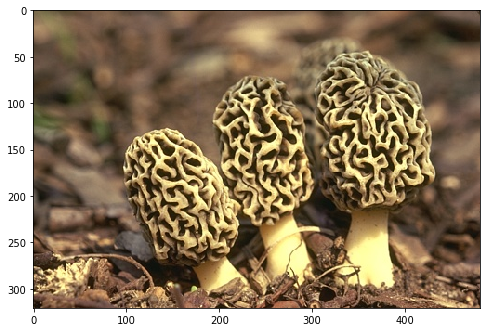

(321, 481, 3)


In [12]:
showImage(images['test'][90])
print(images['test'][90].shape)

In [42]:
# Create dict to hold (noisy) images

images_noisy = {
  'train':[],
  'test':[],
  'val':[]
}

# Add images to the dict

# noisy train images are no longer used:
for image in tqdm(sorted(os.listdir(noisy_train_dir))):
  if '.jpg' in image: # only add .jpg files
    images_noisy['train'] += [cv2.imread(str(noisy_train_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(noisy_test_dir))):
  if '.jpg' in image: # only add .jpg files
    images_noisy['test'] += [cv2.imread(str(noisy_test_dir) + "/" + image)]

# noisy val images are no longer used:
for image in tqdm(sorted(os.listdir(noisy_val_dir))):
  if '.jpg' in image: # only add .jpg files
    images_noisy['val'] += [cv2.imread(str(noisy_val_dir) + "/" + image)]



  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 142.38it/s]

 14%|█▍        | 29/200 [00:00<00:01, 140.57it/s]

 22%|██▏       | 44/200 [00:00<00:01, 142.94it/s]

 30%|██▉       | 59/200 [00:00<00:00, 144.61it/s]

 37%|███▋      | 74/200 [00:00<00:00, 145.33it/s]

 44%|████▍     | 89/200 [00:00<00:00, 145.72it/s]

 52%|█████▏    | 104/200 [00:00<00:00, 145.26it/s]

 59%|█████▉    | 118/200 [00:00<00:00, 142.11it/s]

 66%|██████▌   | 132/200 [00:00<00:00, 140.01it/s]

 73%|███████▎  | 146/200 [00:01<00:00, 139.71it/s]

 80%|████████  | 160/200 [00:01<00:00, 135.70it/s]

 88%|████████▊ | 175/200 [00:01<00:00, 138.98it/s]

 96%|█████████▌| 191/200 [00:01<00:00, 143.94it/s]

100%|██████████| 200/200 [00:01<00:00, 142.57it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 163.78it/s]

 16%|█▌        | 32/200 [00:00<00:01, 157.33it/s]

 24%|██▎       | 47/200 [00:00<00:00, 154.93it/s]

 30%|███       | 61/200 [00:00<00:00, 147

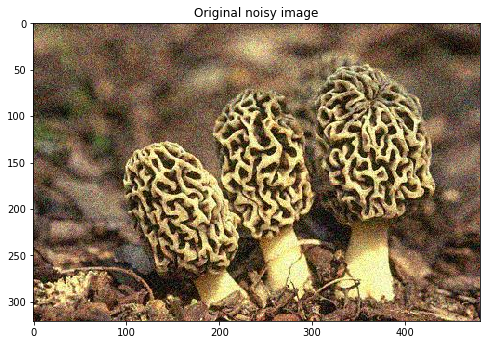

(321, 481, 3)


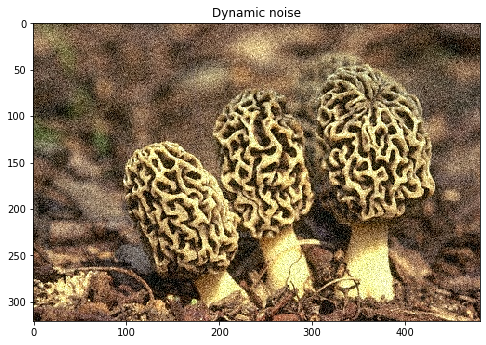

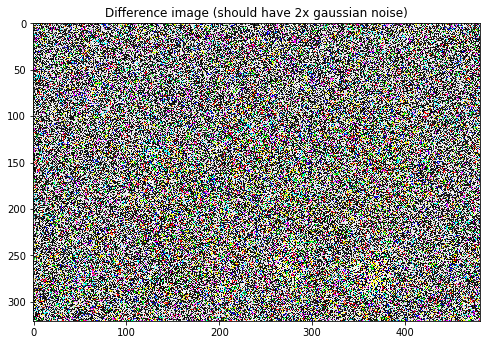

(321, 481, 3)


In [14]:
showImage(images_noisy['test'][90], title='Original noisy image')
print(images_noisy['test'][90].shape)

# test imgaug noise characteristics:
add_noise = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=noise_sigma)
])
double_check = add_noise(images=[images['test'][90]])[0]
showImage(double_check, 'Dynamic noise')
diff = np.abs(images_noisy['test'][90] - double_check)
showImage(diff, title='Difference image (should have 2x gaussian noise)', renormalize=False)
print(double_check.shape)

In [0]:
########################################################

# Custom Keras Data Generators:

class ImageGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, x_path, y_path, batch_size, sigma_=0, crop_size=180, augment=True, shuffle=True, seed=42):
        'Initialization'
        self.x_path = x_path
        self.y_path = y_path
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        np.random.seed(seed)
        self.seed = seed
        self.sigma = sigma_

        # generate the list of images available from x_path
        self.x_image_names = self.get_image_names(self.x_path)
        self.y_image_names = self.get_image_names(self.y_path)

        # for this case, the file names in each path should equal one another:
        assert [os.path.basename(path) for path in self.x_image_names] == \
               [os.path.basename(path) for path in self.y_image_names]

        # convert x_image_names and y_image_names to np arrays for easy indexing
        self.x_image_names = np.array(self.x_image_names)
        self.y_image_names = np.array(self.y_image_names)

        # determine total images in our generator
        self.total_images = len(self.x_image_names)

        self.indexes = []
        self.on_epoch_end()

        # Augmentation pipeline:
        # (1) Crop images to 180x180, in a random place
        # (2) Horizontally flip image 50% of the time
        # (3) Vertically flip image 50% of the time
        self.crop_and_flip = iaa.Sequential([
            iaa.CropToFixedSize(width=crop_size, height=crop_size, position="uniform"),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5)
        ])
        # (4) Rotate the image in a 90 degree interval 75% of the time
        self.rotate_sometimes = iaa.OneOf([
            iaa.Rot90(0),
            iaa.Rot90(1),
            iaa.Rot90(2),
            iaa.Rot90(3)
        ])
        # (5) Add White Gaussian noise
        self.add_noise = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=self.sigma)
        ])

    @staticmethod
    def get_image_names(src_path):
        raw = sorted(os.listdir(src_path))
        return [os.path.join(src_path, name) for name in raw if '.jpg' in name]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.total_images, dtype=np.int32)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        assert int(np.floor(self.total_images / self.batch_size)) > 0
        return int(np.floor(self.total_images / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        x_aug, y_aug = self.__data_generation(indexes)

        return x_aug, y_aug

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'

        # pull in ONLY the images we need
        x_ = [cv2.imread(im_path) for im_path in self.x_image_names[indexes]]
        y_ = [cv2.imread(im_path) for im_path in self.y_image_names[indexes]]

        # Perform augmentations on X
        if self.augment:
            ia.seed(self.seed)
            x_ = self.crop_and_flip(images=x_)
            x_ = self.rotate_sometimes(images=x_)
            if self.sigma > 0:
              x_ = self.add_noise(images=x_)

            ia.seed(self.seed)
            y_ = self.crop_and_flip(images=y_)
            y_ = self.rotate_sometimes(images=y_)

        x_ = np.array(x_)
        y_ = np.array(y_)
        
        # normalize inputs from 0-255 to 0.0-1.0
        if normalize:
            x_ = x_.astype('float32')
            x_ = x_ / 255.0

            y_ = y_.astype('float32')
            y_ = y_ / 255.0

        # update to use new seed next time
        self.seed = np.random.randint(1, 100000)

        return x_, y_

In [0]:
########################################################

# Custom Keras Layers:

# C_0 layer (stores the shared C_0 weight)
class C0(Layer):
    C_0 = None
    kernel_c0 = None

    def __init__(self, C_0, **kwargs):
        self.C_0 = C_0
        super(C0, self).__init__(**kwargs)

    def build(self, _):
        self.kernel_c0 = self.add_weight(name='kernel_c0', shape=(1,), initializer='zeros', trainable=True)
        super(C0, self).build(_)

    def call(self, _):
        return self.kernel_c0 + self.C_0

    def compute_output_shape(self, _):
        return (1,)


# Proximal gradient layer
class ProximalGradient(Layer):
    C_k = None
    kernel_ck = None

    def __init__(self, C_k, **kwargs):
        self.C_k = C_k
        super(ProximalGradient, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel_ck = self.add_weight(name='kernel_ck', shape=(1,), initializer='zeros', trainable=True)
        super(ProximalGradient, self).build(input_shape)

    def call(self, inputs):
        '''
        inputs: [
            x_k: the image after previous ProximalGradient layer
            x_k_12: the image after previous CNN layer
            y: the input image (unfiltered)
            c0: the C_0 layer storing the global C_0 weight
        ]
        '''
        x_k, x_k_12, y, c0 = inputs

        # compute alpha_k
        alpha_k = c0 * (self.kernel_ck + self.C_k)

        # Algorithm 5 implementation:
        x_k_1 = (alpha_k * y + x_k + x_k_12) / (alpha_k + 1)

        # Old implementation
        # x_k_1 = self.sigma ** 2 / (alpha_k + self.sigma ** 2) * (alpha_k / self.sigma ** 2 * y + x_k + x_k_12)

        return x_k_1

    def compute_output_shape(self, input_shape):
        return input_shape

Build the CNN part of the algorithm:

In [0]:
########################################################

# Custom Vanilla Layers:

def createCNN(input_, weight_decay, n=7, batchnorm_at_end=False):
    # initial input layer
    layers = input_

    # Add the n-2 conv layers with 64 channels
    for n_ in range(n - 1):
        if n_ == 0:
            layers = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(layers)
            if not batchnorm_at_end:
                layers = BatchNormalization(axis=-1)(layers)
        else:
            layers = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(layers)
            if not batchnorm_at_end:
                layers = BatchNormalization(axis=-1)(layers)

    # Add the conv layer with 3 channels
    layers = Conv2D(3, kernel_size=(3, 3), activation='softmax' if use_sigmoid else 'relu', padding='same')(layers)
    if batchnorm_at_end:
        layers = BatchNormalization(axis=-1)(layers)

    return layers

Tie the CNN network(s) with the proximal gradient layers

In [18]:
########################################################

# Build the model:

# initialization: x_0
y = Input(shape=image_shape)
x_0 = y

# initialization: C_0
# need any input as a placeholder for this layer (disconnected w/o this input)
c0 = C0(C_0=C_0)(y)

x_k = None
x_k_1 = None
for k in range(N):
    if k == 0:
        x_k = x_0
        cnn_net = createCNN(x_0, weight_decay, n=n, batchnorm_at_end=batchnorm_at_end)
    else:
        cnn_net = createCNN(x_k, weight_decay, n=n, batchnorm_at_end=batchnorm_at_end)

    if proximal_enabled:
        x_k_1 = ProximalGradient(C_k=2 ** -k)([x_k, cnn_net, y, c0])
        # use x_{k+1} as the input to the next CNN in the loop
        x_k = x_k_1
    else:
        x_k = cnn_net

# create the model
model = Model(y, x_k_1 if proximal_enabled else x_k)
print(model.summary())

# write model summary to file
with open(os.path.join(runs_dir, "model_summary.txt"),"w") as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 180, 180, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 180, 180, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 180, 180, 64) 36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
# adding PSNR to list of metrics
if normalize:
    def PSNR(y_true, y_pred):
        max_pixel = 1.0
        return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true + 1e-4), axis=-1)))) / 2.303
else:
    def PSNR(y_true, y_pred):
        max_pixel = 255.0
        return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true + 1e-4), axis=-1)))) / 2.303

metrics = [PSNR]

In [0]:
# compile the model with a loss function:

adam = tfa.optimizers.AdamW(learning_rate=learning_rate, lr=learning_rate, beta_1=beta_1, beta_2=beta_2, weight_decay=weight_decay)
model.compile(loss='mean_squared_error', metrics=metrics, optimizer=adam)

In [0]:
########################################################

# Training the model

# define step decay:
def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5  # factor of 0.5
    epochs_drop = 300  # every 300 epochs
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

lr_step = LearningRateScheduler(step_decay)

# define the generators:
training_generator = ImageGenerator(train_dir, train_dir, batch_size, sigma_=noise_sigma, crop_size=image_shape[0])
validation_generator = ImageGenerator(val_dir, val_dir, batch_size, sigma_=noise_sigma, crop_size=image_shape[0])

In [22]:
########################################################

# Add logger and checkpointer

def tensorboard():
    # starting tensorboard: tensorboard --logdir=run1:logs/ --port 6006
    print('--- enabling TensorBoard')
    return TensorBoard(log_dir=logs_dir, histogram_freq=0, 
                       write_graph=True, write_images=True)

def checkpointer():
    print('--- enabling Checkpointer')
    return ModelCheckpoint(filepath=os.path.join(model_dir, 'e{epoch:002d}.h5'), 
                           monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

callbacks = [checkpointer(), tensorboard()]#, lr_step]

--- enabling Checkpointer
--- enabling TensorBoard


In [23]:
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              use_multiprocessing=use_multiprocessing,
                              workers=workers,
                              callbacks=callbacks,
                              verbose=1)

# save history as pickle file:
with open(os.path.join(runs_dir, 'history.pickle'), 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/200
50/50 [==============================] - 48s 951ms/step - loss: 0.0090 - PSNR: 26.0199 - val_loss: 0.0093 - val_PSNR: 25.9374


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/200
50/50 [==============================] - 39s 783ms/step - loss: 0.0089 - PSNR: 25.9094 - val_loss: 0.0088 - val_PSNR: 26.0080
Epoch 3/200
50/50 [==============================] - 39s 780ms/step - loss: 0.0089 - PSNR: 25.9079 - val_loss: 0.0093 - val_PSNR: 25.9844
Epoch 4/200
50/50 [==============================] - 39s 780ms/step - loss: 0.0090 - PSNR: 25.8634 - val_loss: 0.0087 - val_PSNR: 25.9346
Epoch 5/200
50/50 [==============================] - 39s 775ms/step - loss: 0.0090 - PSNR: 25.8017 - val_loss: 0.0091 - val_PSNR: 25.9621
Epoch 6/200
50/50 [==============================] - 39s 781ms/step - loss: 0.0090 - PSNR: 25.8265 - val_loss: 0.0091 - val_PSNR: 25.9032
Epoch 7/200
50/50 [==============================] - 39s 782ms/step - loss: 0.0090 - PSNR: 25.7406 - val_loss: 0.0083 - val_PSNR: 25.5364
Epoch 8/200
50/50 [==============================] - 39s 777ms/step - loss: 0.0074 - PSNR: 25.1184 - val_loss: 0.0080 - val_PSNR: 24.5355
Epoch 9/200
50/50 [===============

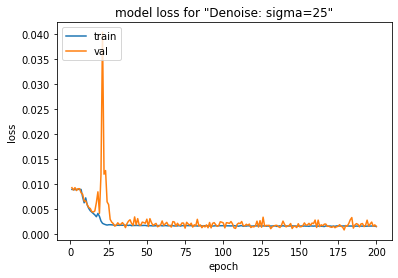

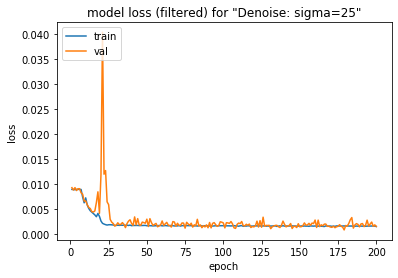

In [24]:
# # summarize history for loss
plt.plot([x + 1 for x in range(len(history.history['loss']))], history.history['loss'])
plt.plot([x + 1 for x in range(len(history.history['val_loss']))], history.history['val_loss'])
plt.title('model loss for "Denoise: sigma={}"'.format(sigma))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_loss'))
plt.show()

# # summarize history for loss (filtered)
plt.plot([idx + 1 for idx, x in enumerate(history.history['loss']) if x < 1], [x for x in history.history['loss'] if x < 1])
plt.plot([idx + 1 for idx, x in enumerate(history.history['val_loss']) if x < 1], [x for x in history.history['val_loss'] if x < 1])
plt.title('model loss (filtered) for "Denoise: sigma={}"'.format(sigma))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_loss_f'))
plt.show()

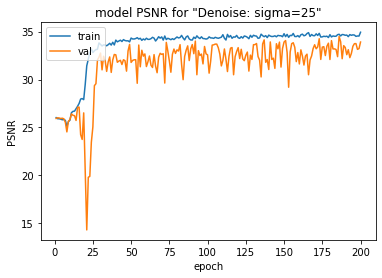

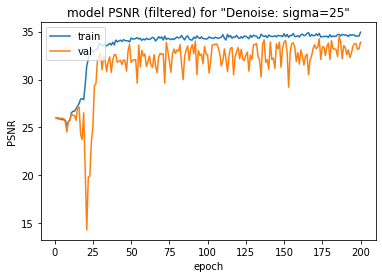

In [32]:
# # summarize history for PSNR
plt.plot([x + 1 for x in range(len(history.history['PSNR']))], history.history['PSNR'])
plt.plot([x + 1 for x in range(len(history.history['val_PSNR']))], history.history['val_PSNR'])
plt.title('model PSNR for "Denoise: sigma={}"'.format(sigma))
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_psnr'))
plt.show()

# # summarize history for PSNR (filtered)
plt.plot([idx + 1 for idx, x in enumerate(history.history['PSNR']) if x > 0], [x for x in history.history['PSNR'] if x > 0])
plt.plot([idx + 1 for idx, x in enumerate(history.history['val_PSNR']) if x > 0], [x for x in history.history['val_PSNR'] if x > 0])
plt.title('model PSNR (filtered) for "Denoise: sigma={}"'.format(sigma))
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_psnr_f'))
plt.show()

In [26]:
# serialize weights to HDF5
print("Saving model to disk (_e{0:002d}.h5)".format(epochs))
model.save_weights(os.path.join(model_dir, "_e{0:002d}.h5".format(epochs)))

Saving model to disk (_e200.h5)


In [0]:
# define training sets
x_set = images_noisy['test']
y_set = images['test']

# image cropping
crop_this = iaa.Sequential([
  iaa.CropToFixedSize(width=image_shape[0], height=image_shape[1], position="uniform")
])
ia.seed(1)
x_input = np.array(crop_this(images=x_set))
ia.seed(1)
y_input = np.array(crop_this(images=y_set))

# normalize
if normalize:
    x_input = x_input.astype('float32')
    x_input = x_input / 255.0

    y_input = y_input.astype('float32')
    y_input = y_input / 255.0

In [28]:
# load the best-performing model:
model_weights = [int(x[1:][:2]) for x in os.listdir(model_dir) if "_e" not in x]
if len(model_weights) == 0:
    best_weight = "_e{0:002d}.h5".format(epochs)
else:
    model_weights = sorted(model_weights)
    best_weight = "e{}.h5".format(model_weights[-1])

print("Loading weights from '{}'".format(os.path.join(model_dir, best_weight)))
model.load_weights(os.path.join(model_dir, best_weight))

Loading weights from '/content/gdrive/My Drive/239ASCompImagingData/runs/denoising/run-14/model/e75.h5'


In [0]:
# evaluate the network
# NOTE: we are not using the noisy sets, just blurring the original images

def evaluate_model(eval_type='test', seed=1):

    print('='*30)
    print('Evaluating using {} set'.format(eval_type))

    # make a folder to place eval results into
    eval_dir = os.path.join(runs_dir, '{}_evaluation'.format(eval_type))
    print(eval_dir)
    if not os.path.exists(eval_dir):
        os.mkdir(eval_dir)

    # image noising
    x_set = images_noisy[eval_type]
    y_set = images[eval_type]

    # image cropping
    crop_this = iaa.Sequential([
        iaa.CropToFixedSize(width=image_shape[0], height=image_shape[1], position="uniform")
    ])
    ia.seed(seed)
    x_input = np.array(crop_this(images=x_set))
    ia.seed(seed)
    y_input = np.array(crop_this(images=y_set))

    # normalize
    if normalize:
        x_input = x_input.astype('float32')
        x_input = x_input / 255.0

        y_input = y_input.astype('float32')
        y_input = y_input / 255.0

    # model evals
    x_hat = model.predict(x_input)
    errors = model.evaluate(x_input, y_input)
    print('PSNR of model evaluated on {} set: {}'.format(eval_type, errors[1]))
    print('Loss of model evaluated on {} set: {}'.format(eval_type, errors[0]))

    with open(os.path.join(runs_dir, 'evaluation_summary.txt'), 'a+') as eval_txt:
        print('PSNR of model evaluated on {} set: {}\n'.format(eval_type, errors[1]), file=eval_txt)
        print('Loss of model evaluated on {} set: {}\n'.format(eval_type, errors[0]), file=eval_txt)
        print('\n', file=eval_txt)

    # export results on data
    def show_results(i=0):
        result_dir = os.path.join(eval_dir, 'sample-{}'.format(i))
        if not os.path.exists(result_dir):
            os.mkdir(result_dir)

        showImage(x_input[i], normalized=normalize, title="x_input example {}".format(i), saveto=os.path.join(result_dir, 'x_input_ex{}'.format(i)))
        showImage(x_hat[i], normalized=normalize, title="x_hat example {}".format(i), saveto=os.path.join(result_dir, 'x_hat_ex{}'.format(i)))
        showImage(y_input[i], normalized=normalize, title="y_input example {}".format(i), saveto=os.path.join(result_dir, 'y_input_ex{}'.format(i)))

    show_results(0)
    print('-'*100)
    show_results(90)
    print('-'*100)
    show_results(99)

    print('=' * 30)
    print()

Evaluating using train set
/content/gdrive/My Drive/239ASCompImagingData/runs/denoising/run-14/train_evaluation
200/200 [==============================] - 10s 49ms/step
PSNR of model evaluated on train set: 30.440505981445312
Loss of model evaluated on train set: 0.0019440352730453014


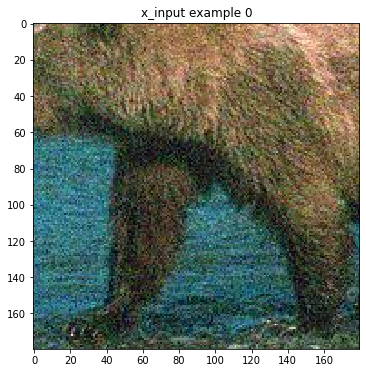

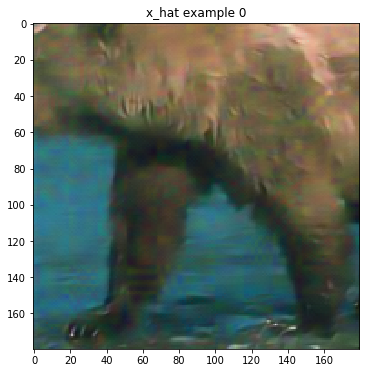

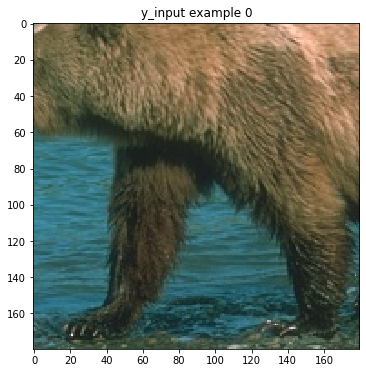

----------------------------------------------------------------------------------------------------


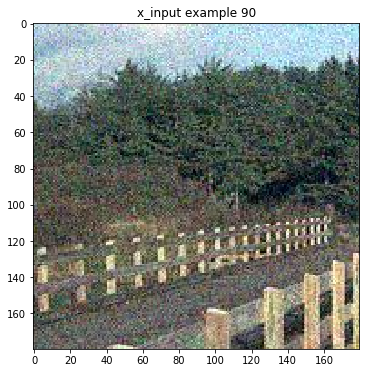

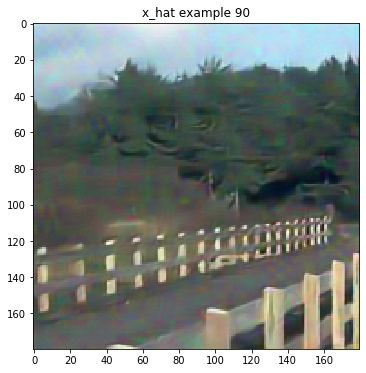

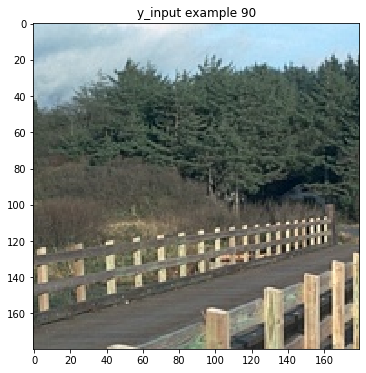

----------------------------------------------------------------------------------------------------


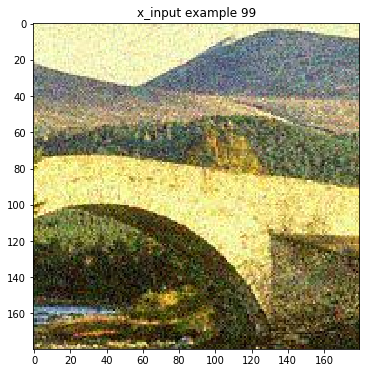

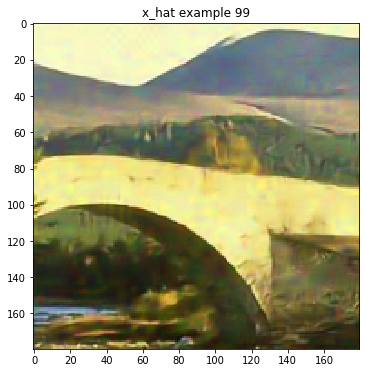

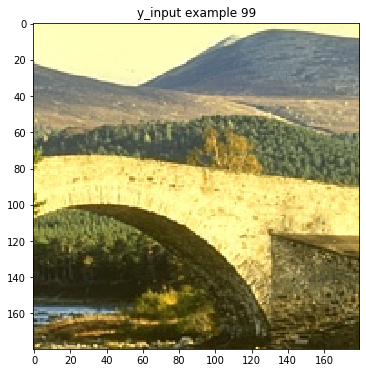


Evaluating using val set
/content/gdrive/My Drive/239ASCompImagingData/runs/denoising/run-14/val_evaluation
100/100 [==============================] - 5s 49ms/step
PSNR of model evaluated on val set: 30.261730194091797
Loss of model evaluated on val set: 0.0020835035666823386


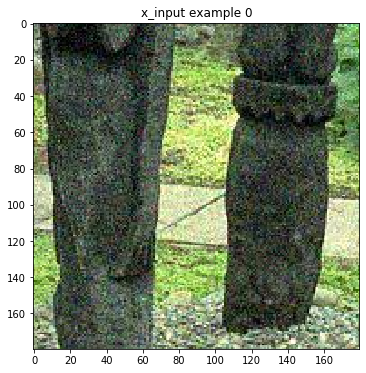

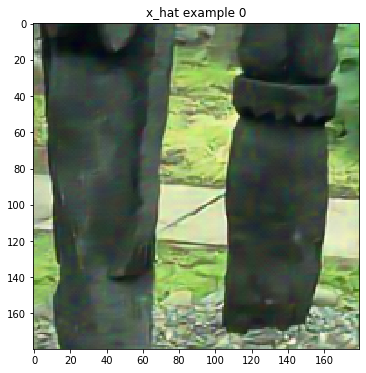

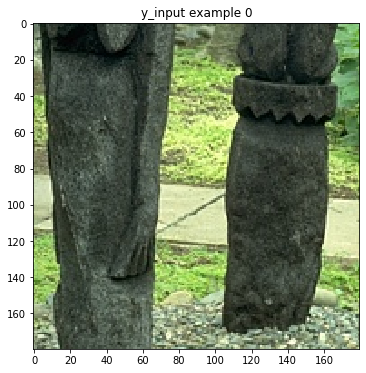

----------------------------------------------------------------------------------------------------


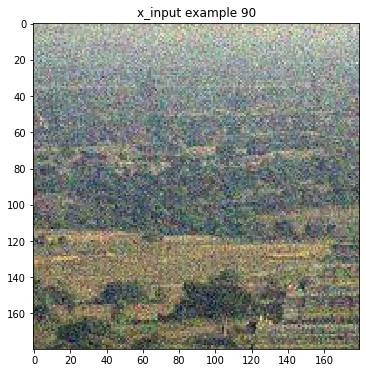

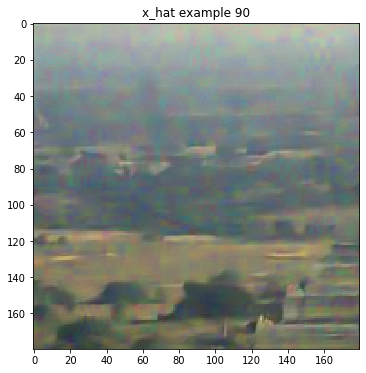

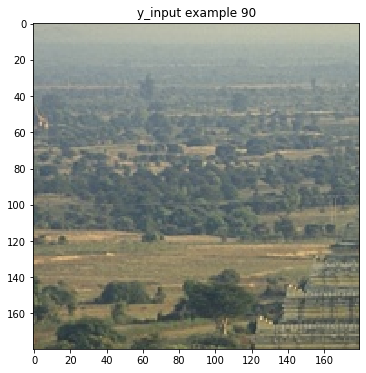

----------------------------------------------------------------------------------------------------


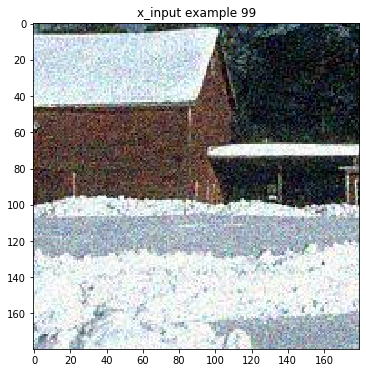

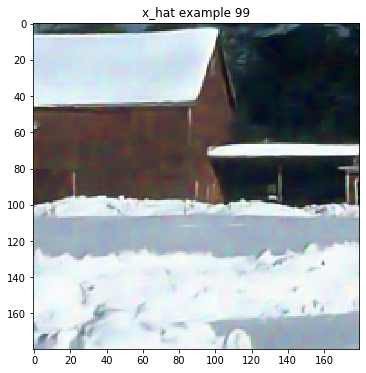

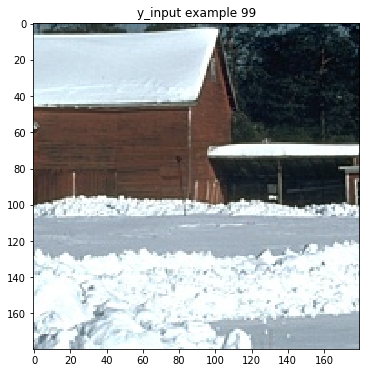


Evaluating using test set
/content/gdrive/My Drive/239ASCompImagingData/runs/denoising/run-14/test_evaluation
200/200 [==============================] - 10s 49ms/step
PSNR of model evaluated on test set: 30.35866355895996
Loss of model evaluated on test set: 0.0019841162767261266


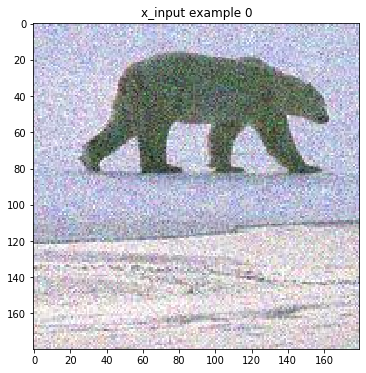

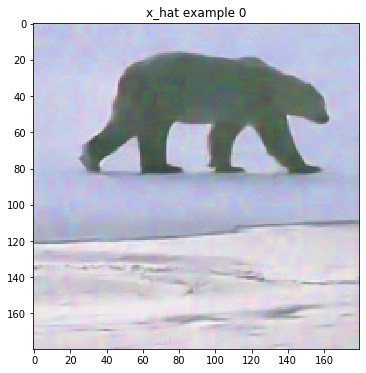

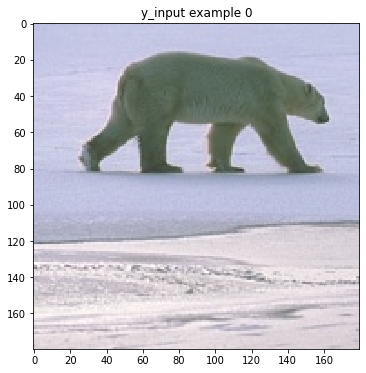

----------------------------------------------------------------------------------------------------


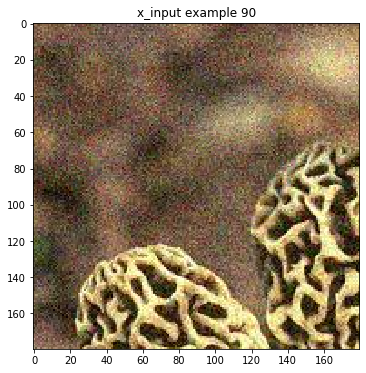

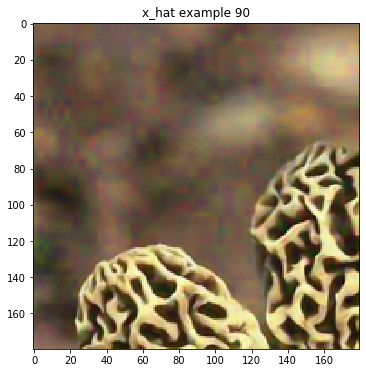

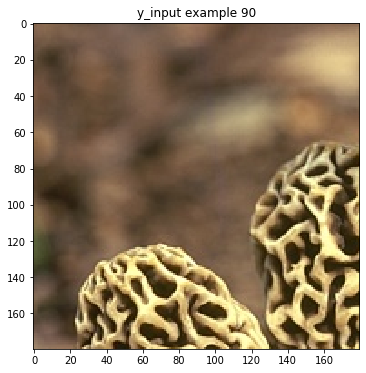

----------------------------------------------------------------------------------------------------


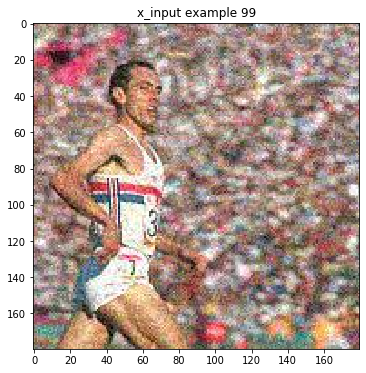

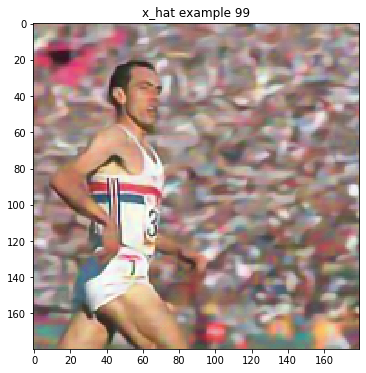

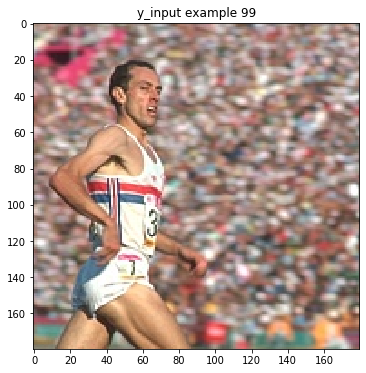

In [44]:
# gather data of the best model for all datasets
evaluate_model('train')
evaluate_model('val')
evaluate_model('test')